## Module import 

In [1]:
#LGBM
import lightgbm as lgb

#Tensorflow , keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping, Callback
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical ,Sequence, get_custom_objects
#from swa.keras import SWA # swa optimizer - https://pypi.org/project/keras-swa/
from tensorflow.keras.models import load_model

#etc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import json

In [2]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('tensorflow : %s'%(tf.__version__))
!python --version

Pandas : 1.0.1
Numpy : 1.18.1
tensorflow : 2.2.0
Python 3.7.6


## Data Call 

In [ ]:
# data_df = pd.read_csv('data/201901-202003.csv')
# display(data_df)

## Data Preprocess 1 

In [ ]:
# col = ['REG_YYMM','CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']
# pre_data_df  = data_df[col]
# group = pre_data_df.groupby([pre_data_df['REG_YYMM'],pre_data_df['CARD_SIDO_NM'],pre_data_df['STD_CLSS_NM']]).sum()
# group.to_csv('data/group_myoung.csv', encoding='utf-8-sig')

## Data Preprocess 2

In [225]:
group_df = pd.read_csv('data/group_myoung.csv')

In [226]:
group_df

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,201901,강원,건강보조식품 소매업,148354746
1,201901,강원,골프장 운영업,1229200312
2,201901,강원,과실 및 채소 소매업,1286979106
3,201901,강원,관광 민예품 및 선물용품 소매업,30656770
4,201901,강원,그외 기타 스포츠시설 운영업,13101500
...,...,...,...,...
9433,202003,충북,피자 햄버거 샌드위치 및 유사 음식점업,1315245299
9434,202003,충북,한식 음식점업,16152482704
9435,202003,충북,호텔업,15248550
9436,202003,충북,화장품 및 방향제 소매업,428881434


In [5]:
CARD_SIDO_NM_list = list(group_df['CARD_SIDO_NM'].unique())
STD_CLSS_NM_list =  list(group_df['STD_CLSS_NM'].unique())

for i in range(len(CARD_SIDO_NM_list)):
    tmp_city = CARD_SIDO_NM_list[i]
    group_df['CARD_SIDO_NM'].replace(tmp_city,i,inplace=True)

for i in range(len(STD_CLSS_NM_list)):
    tmp_CLSS = STD_CLSS_NM_list[i]
    group_df['STD_CLSS_NM'].replace(tmp_CLSS,i,inplace=True)

In [6]:
group_df

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,201901,0,0,148354746
1,201901,0,1,1229200312
2,201901,0,2,1286979106
3,201901,0,3,30656770
4,201901,0,4,13101500
...,...,...,...,...
9433,202003,16,34,1315245299
9434,202003,16,35,16152482704
9435,202003,16,36,15248550
9436,202003,16,37,428881434


## KERAS 

In [7]:
train_X = group_df[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']]
train_Y = group_df['AMT']

In [415]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=3))
model.add(Dropout(0.9))

model.add(Dense(150, activation='relu'))
model.add(Dropout(0.9))

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.9))

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.9))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.9))

model.add(Dense(150, activation='relu'))
model.add(Dropout(0.9))

# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.7))


#model.add(BatchNormalization())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(80, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(1100, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(600, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(10, activation='relu'))
# model.add(BatchNormalization())

model.add(Dense(1, activation='linear')) # OUTPUT
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 100)               400       
_________________________________________________________________
dropout_50 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 150)               15150     
_________________________________________________________________
dropout_51 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 200)               30200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 250)             

In [416]:
def custom_rmsle(y_true, y_pred):
       return K.sqrt(K.mean(K.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

In [417]:
model.compile(loss='mean_squared_logarithmic_error',
              optimizer='adam',
              metrics=[custom_rmsle]
             )

In [418]:
model_name = 'MLP_test'
version = '2'
model_path = 'data/history/'+model_name+'_'+version+'.hdf5'

earlystopper = EarlyStopping(
    monitor='val_loss', 
    patience=100, 
    verbose=1,
    mode='min'
)
modelsaver = ModelCheckpoint(
    model_path, 
    monitor='val_loss', 
    verbose=1, 
    #save_best_only=True,
    save_weights_only=True,
    mode='min'
    #period=50
)
lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=20,
    verbose=1,
    min_lr=5e-10
)

In [419]:
# model.load_weights('data/history/MLP_test.hdf5')

In [420]:
epoch_num = 50000
batch_size_num = 6000
validation_split_nm =  0.05
hist = model.fit(train_X, 
                 train_Y, 
                 epochs=epoch_num, 
                 batch_size=batch_size_num, 
                 validation_split=validation_split_nm, 
                 callbacks=[earlystopper,modelsaver,lrreducer]
                )

Epoch 1/50000
2/2 [==============================] - ETA: 0s - loss: 231.3133 - custom_rmsle: nan
Epoch 00001: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 199ms/step - loss: 231.3133 - custom_rmsle: nan - val_loss: 120.3225 - val_custom_rmsle: 10.9692 - lr: 0.0010
Epoch 2/50000
2/2 [==============================] - ETA: 0s - loss: 190.9790 - custom_rmsle: nan
Epoch 00002: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 138ms/step - loss: 190.9790 - custom_rmsle: nan - val_loss: 103.1833 - val_custom_rmsle: 10.1579 - lr: 0.0010
Epoch 3/50000
2/2 [==============================] - ETA: 0s - loss: 161.1875 - custom_rmsle: nan
Epoch 00003: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 141ms/step - loss: 161.1875 - custom_rmsle: nan - val_loss: 94.1386 - val_custom_rmsle: 9.7025 - lr: 0.0010
Epoch 4/50000
2/2 [==============================] - ETA: 0s - loss: 132.8184 

Epoch 28/50000
2/2 [==============================] - ETA: 0s - loss: 22.1126 - custom_rmsle: nan
Epoch 00028: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 118ms/step - loss: 22.1126 - custom_rmsle: nan - val_loss: 32.8145 - val_custom_rmsle: 5.7284 - lr: 0.0010
Epoch 29/50000
2/2 [==============================] - ETA: 0s - loss: 21.5389 - custom_rmsle: nan
Epoch 00029: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 144ms/step - loss: 21.5389 - custom_rmsle: nan - val_loss: 31.7255 - val_custom_rmsle: 5.6325 - lr: 0.0010
Epoch 30/50000
2/2 [==============================] - ETA: 0s - loss: 20.7970 - custom_rmsle: nan
Epoch 00030: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 149ms/step - loss: 20.7970 - custom_rmsle: nan - val_loss: 30.6858 - val_custom_rmsle: 5.5395 - lr: 0.0010
Epoch 31/50000
2/2 [==============================] - ETA: 0s - loss: 21.0451 - custo

Epoch 55/50000
2/2 [==============================] - ETA: 0s - loss: 14.4950 - custom_rmsle: nan
Epoch 00055: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 133ms/step - loss: 14.4950 - custom_rmsle: nan - val_loss: 15.1474 - val_custom_rmsle: 3.8920 - lr: 0.0010
Epoch 56/50000
2/2 [==============================] - ETA: 0s - loss: 14.3461 - custom_rmsle: nan
Epoch 00056: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 126ms/step - loss: 14.3461 - custom_rmsle: nan - val_loss: 14.8263 - val_custom_rmsle: 3.8505 - lr: 0.0010
Epoch 57/50000
2/2 [==============================] - ETA: 0s - loss: 13.7435 - custom_rmsle: nan
Epoch 00057: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 132ms/step - loss: 13.7435 - custom_rmsle: nan - val_loss: 14.5214 - val_custom_rmsle: 3.8107 - lr: 0.0010
Epoch 58/50000
2/2 [==============================] - ETA: 0s - loss: 13.7718 - custo

Epoch 82/50000
2/2 [==============================] - ETA: 0s - loss: 11.9323 - custom_rmsle: nan
Epoch 00082: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 118ms/step - loss: 11.9323 - custom_rmsle: nan - val_loss: 10.3687 - val_custom_rmsle: 3.2201 - lr: 0.0010
Epoch 83/50000
2/2 [==============================] - ETA: 0s - loss: 11.7839 - custom_rmsle: nan
Epoch 00083: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 114ms/step - loss: 11.7839 - custom_rmsle: nan - val_loss: 10.2912 - val_custom_rmsle: 3.2080 - lr: 0.0010
Epoch 84/50000
2/2 [==============================] - ETA: 0s - loss: 11.8713 - custom_rmsle: nan
Epoch 00084: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 116ms/step - loss: 11.8713 - custom_rmsle: nan - val_loss: 10.2180 - val_custom_rmsle: 3.1966 - lr: 0.0010
Epoch 85/50000
2/2 [==============================] - ETA: 0s - loss: 11.6067 - custo

Epoch 109/50000
2/2 [==============================] - ETA: 0s - loss: 10.6470 - custom_rmsle: nan
Epoch 00109: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 118ms/step - loss: 10.6470 - custom_rmsle: nan - val_loss: 9.2911 - val_custom_rmsle: 3.0481 - lr: 0.0010
Epoch 110/50000
2/2 [==============================] - ETA: 0s - loss: 10.9584 - custom_rmsle: 3.3072
Epoch 00110: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 133ms/step - loss: 10.9584 - custom_rmsle: 3.3072 - val_loss: 9.2767 - val_custom_rmsle: 3.0458 - lr: 0.0010
Epoch 111/50000
2/2 [==============================] - ETA: 0s - loss: 10.7338 - custom_rmsle: nan
Epoch 00111: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 129ms/step - loss: 10.7338 - custom_rmsle: nan - val_loss: 9.2632 - val_custom_rmsle: 3.0435 - lr: 0.0010
Epoch 112/50000
2/2 [==============================] - ETA: 0s - loss: 10.6208 

Epoch 136/50000
2/2 [==============================] - ETA: 0s - loss: 10.7273 - custom_rmsle: nan
Epoch 00136: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 131ms/step - loss: 10.7273 - custom_rmsle: nan - val_loss: 9.1224 - val_custom_rmsle: 3.0203 - lr: 0.0010
Epoch 137/50000
2/2 [==============================] - ETA: 0s - loss: 10.6896 - custom_rmsle: nan
Epoch 00137: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 130ms/step - loss: 10.6896 - custom_rmsle: nan - val_loss: 9.1213 - val_custom_rmsle: 3.0201 - lr: 0.0010
Epoch 138/50000
2/2 [==============================] - ETA: 0s - loss: 10.4107 - custom_rmsle: 3.2211
Epoch 00138: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 116ms/step - loss: 10.4107 - custom_rmsle: 3.2211 - val_loss: 9.1203 - val_custom_rmsle: 3.0200 - lr: 0.0010
Epoch 139/50000
2/2 [==============================] - ETA: 0s - loss: 10.2107 

2/2 [==============================] - 0s 149ms/step - loss: 10.4040 - custom_rmsle: nan - val_loss: 9.1233 - val_custom_rmsle: 3.0205 - lr: 0.0010
Epoch 163/50000
2/2 [==============================] - ETA: 0s - loss: 10.3013 - custom_rmsle: nan
Epoch 00163: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 134ms/step - loss: 10.3013 - custom_rmsle: nan - val_loss: 9.1238 - val_custom_rmsle: 3.0206 - lr: 0.0010
Epoch 164/50000
2/2 [==============================] - ETA: 0s - loss: 10.4974 - custom_rmsle: 3.2461
Epoch 00164: saving model to data/history/MLP_test_2.hdf5

Epoch 00164: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2/2 [==============================] - 0s 151ms/step - loss: 10.4974 - custom_rmsle: 3.2461 - val_loss: 9.1243 - val_custom_rmsle: 3.0207 - lr: 0.0010
Epoch 165/50000
2/2 [==============================] - ETA: 0s - loss: 10.3317 - custom_rmsle: 3.2235
Epoch 00165: saving model to data/history/MLP_test_2

2/2 [==============================] - ETA: 0s - loss: 10.1098 - custom_rmsle: 3.1696
Epoch 00188: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 154ms/step - loss: 10.1098 - custom_rmsle: 3.1696 - val_loss: 9.1252 - val_custom_rmsle: 3.0208 - lr: 1.0000e-05
Epoch 189/50000
2/2 [==============================] - ETA: 0s - loss: 10.5026 - custom_rmsle: 3.2375
Epoch 00189: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 123ms/step - loss: 10.5026 - custom_rmsle: 3.2375 - val_loss: 9.1252 - val_custom_rmsle: 3.0208 - lr: 1.0000e-05
Epoch 190/50000
2/2 [==============================] - ETA: 0s - loss: 10.6585 - custom_rmsle: 3.2642
Epoch 00190: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 130ms/step - loss: 10.6585 - custom_rmsle: 3.2642 - val_loss: 9.1253 - val_custom_rmsle: 3.0208 - lr: 1.0000e-05
Epoch 191/50000
2/2 [==============================] - ETA: 0s - loss: 

Epoch 214/50000
2/2 [==============================] - ETA: 0s - loss: 10.4456 - custom_rmsle: nan   
Epoch 00214: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 125ms/step - loss: 10.4456 - custom_rmsle: nan - val_loss: 9.1253 - val_custom_rmsle: 3.0208 - lr: 1.0000e-06
Epoch 215/50000
2/2 [==============================] - ETA: 0s - loss: 10.3209 - custom_rmsle: 3.2292
Epoch 00215: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 138ms/step - loss: 10.3209 - custom_rmsle: 3.2292 - val_loss: 9.1253 - val_custom_rmsle: 3.0208 - lr: 1.0000e-06
Epoch 216/50000
2/2 [==============================] - ETA: 0s - loss: 10.3413 - custom_rmsle: nan
Epoch 00216: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 107ms/step - loss: 10.3413 - custom_rmsle: nan - val_loss: 9.1253 - val_custom_rmsle: 3.0208 - lr: 1.0000e-06
Epoch 217/50000
2/2 [==============================] - ETA: 0s -

Epoch 240/50000
2/2 [==============================] - ETA: 0s - loss: 10.6013 - custom_rmsle: 3.2536
Epoch 00240: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 120ms/step - loss: 10.6013 - custom_rmsle: 3.2536 - val_loss: 9.1253 - val_custom_rmsle: 3.0208 - lr: 1.0000e-07
Epoch 241/50000
2/2 [==============================] - ETA: 0s - loss: 10.5824 - custom_rmsle: nan
Epoch 00241: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 129ms/step - loss: 10.5824 - custom_rmsle: nan - val_loss: 9.1253 - val_custom_rmsle: 3.0208 - lr: 1.0000e-07
Epoch 242/50000
2/2 [==============================] - ETA: 0s - loss: 10.5265 - custom_rmsle: 3.2484
Epoch 00242: saving model to data/history/MLP_test_2.hdf5
2/2 [==============================] - 0s 135ms/step - loss: 10.5265 - custom_rmsle: 3.2484 - val_loss: 9.1253 - val_custom_rmsle: 3.0208 - lr: 1.0000e-07
Epoch 243/50000
2/2 [==============================] - ETA: 0

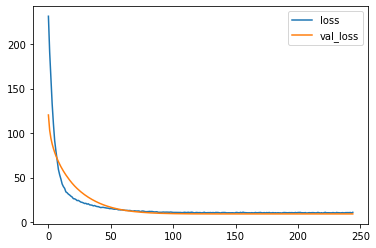

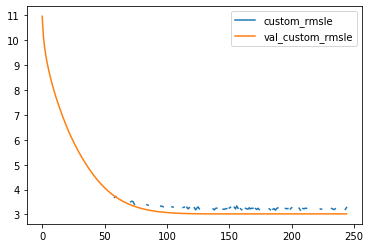

In [421]:
history_file = 'data/history/history_{}.txt'.format(str(version))
dict_to_save = {}
for k, v in hist.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in hist.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = epoch_num
plt.plot(hist.history['loss'][:ep_max], label='loss')
plt.plot(hist.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(hist.history['custom_rmsle'][:ep_max], label='custom_rmsle')
plt.plot(hist.history['val_custom_rmsle'][:ep_max], label='val_custom_rmsle')
plt.legend()
plt.show()

## SUBMISSION 

In [422]:
sub_df = pd.read_csv('data/submission.csv')

In [423]:
tmp_sub = sub_df.copy()
#sub_CARD_SIDO_NM_list = list(tmp_sub['CARD_SIDO_NM'].unique())
#sub_STD_CLSS_NM_list =  list(tmp_sub['STD_CLSS_NM'].unique())

for i in range(len(CARD_SIDO_NM_list)):
    tmp_city = CARD_SIDO_NM_list[i]
    tmp_sub['CARD_SIDO_NM'].replace(tmp_city,i,inplace=True)

for i in range(len(STD_CLSS_NM_list)):
    tmp_CLSS = STD_CLSS_NM_list[i]
    tmp_sub['STD_CLSS_NM'].replace(tmp_CLSS,i,inplace=True)

In [424]:
tmp_sub

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,0,0,0
1,1,202004,0,1,0
2,2,202004,0,2,0
3,3,202004,0,3,0
4,4,202004,0,39,0
...,...,...,...,...,...
1389,1389,202007,16,34,0
1390,1390,202007,16,35,0
1391,1391,202007,16,36,0
1392,1392,202007,16,37,0


In [425]:
test_X = tmp_sub[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']]

In [426]:
test_Y = model.predict(test_X)

In [427]:
for i in test_Y:
    print(i)

[4.506284e+08]
[4.5062893e+08]
[4.5062957e+08]
[4.5063008e+08]
[4.5065e+08]
[4.506306e+08]
[4.5063117e+08]
[4.5063178e+08]
[4.5063226e+08]
[4.5063283e+08]
[4.5063344e+08]
[4.5063395e+08]
[4.506345e+08]
[4.5063504e+08]
[4.5063565e+08]
[4.5063616e+08]
[4.5063667e+08]
[4.506373e+08]
[4.5063782e+08]
[4.506384e+08]
[4.5063894e+08]
[4.506395e+08]
[4.5064e+08]
[4.5064064e+08]
[4.506411e+08]
[4.506416e+08]
[4.5064224e+08]
[4.5064275e+08]
[4.5064326e+08]
[4.506439e+08]
[4.506505e+08]
[4.506444e+08]
[4.50645e+08]
[4.506455e+08]
[4.5064608e+08]
[4.5064662e+08]
[4.506472e+08]
[4.5064774e+08]
[4.5064826e+08]
[4.5064883e+08]
[4.506494e+08]
[4.5062912e+08]
[4.506297e+08]
[4.5063027e+08]
[4.506308e+08]
[4.506507e+08]
[4.506314e+08]
[4.506319e+08]
[4.5063242e+08]
[4.5063302e+08]
[4.5063357e+08]
[4.506341e+08]
[4.506347e+08]
[4.506352e+08]
[4.506358e+08]
[4.5063632e+08]
[4.5063686e+08]
[4.5063744e+08]
[4.5063795e+08]
[4.5063853e+08]
[4.5063914e+08]
[4.506396e+08]
[4.506402e+08]
[4.5064077e+08]
[4.506412

[4.5065626e+08]
[4.5065683e+08]
[4.506573e+08]
[4.5065786e+08]
[4.5065843e+08]
[4.50659e+08]
[4.5065962e+08]
[4.506601e+08]
[4.5066067e+08]
[4.5066122e+08]
[4.50641e+08]
[4.5064147e+08]
[4.506421e+08]
[4.5064262e+08]
[4.5066246e+08]
[4.5064314e+08]
[4.506437e+08]
[4.506443e+08]
[4.5064486e+08]
[4.506454e+08]
[4.5064598e+08]
[4.506465e+08]
[4.5064704e+08]
[4.5064755e+08]
[4.5064813e+08]
[4.506487e+08]
[4.5064928e+08]
[4.506498e+08]
[4.5065037e+08]
[4.5065094e+08]
[4.506514e+08]
[4.5065197e+08]
[4.5065254e+08]
[4.5065312e+08]
[4.506537e+08]
[4.5065424e+08]
[4.5065485e+08]
[4.506553e+08]
[4.506558e+08]
[4.5065645e+08]
[4.5066307e+08]
[4.5065693e+08]
[4.506575e+08]
[4.506581e+08]
[4.5065862e+08]
[4.506592e+08]
[4.506598e+08]
[4.5066022e+08]
[4.5066086e+08]
[4.506614e+08]
[4.5066195e+08]
[4.506416e+08]
[4.5064224e+08]
[4.506428e+08]
[4.5064336e+08]
[4.5066326e+08]
[4.5064394e+08]
[4.5064448e+08]
[4.5064506e+08]
[4.5064557e+08]
[4.5064614e+08]
[4.5064672e+08]
[4.506472e+08]
[4.506478e+08]
[4

In [428]:
sub_df.drop(['id'],axis = 1, inplace=True)

In [429]:
sub_df['AMT'] = test_Y

In [430]:
sub_df

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,450628416.0
1,202004,강원,골프장 운영업,450628928.0
2,202004,강원,과실 및 채소 소매업,450629568.0
3,202004,강원,관광 민예품 및 선물용품 소매업,450630080.0
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,450649984.0
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,450665632.0
1390,202007,충북,한식 음식점업,450666112.0
1391,202007,충북,호텔업,450666752.0
1392,202007,충북,화장품 및 방향제 소매업,450667264.0


In [431]:
sub_df.index.name = 'id'
sub_df.to_csv('submission.csv', encoding='utf-8-sig')

In [ ]:
submission = pd.read_csv('data/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('submission.csv', encoding='utf-8-sig')
submission.head()